# 最終検査予測

目的: 

- 工程途中の検査結果を用いて、最終検査に近い射出検査の結果を予測する。
- 失報や誤報による費用ロスを加味して、予測閾値を決定する。

# 検査結果データの読み込み・前処理

# ノック1. Excelファイルからデータを読み込む

In [1]:
import pandas as pd

# ウエハ容量検査のデータを読み込む
df_wafer = pd.read_excel('ウエハ容量～最終検査_各特徴量の集約.xlsx', 
                         sheet_name='ウエハ容量検査',
                         index_col=0)
# 結果の確認
df_wafer.head()

,ウエハID,3_ウエハ容量最小値,3_ウエハ容量最大値,3_ウエハ容量レンジ,3_ウエハ容量平均値,3_ウエハ容量1~10ch平均値,3_ウエハ容量247~256ch平均値,3_ウエハ容量中央値,3_ウエハ容量チャンネル001,3_ウエハ容量チャンネル128,3_ウエハ容量チャンネル256,3_ウエハ容量標準偏差,3_ウエハ容量分散
No,,,,,,,,,,,,,
1,X10002,10443.60,10809.80,366.20,10660.170117,10800.725,10586.695,10635.375,10801.15,10645.10,10593.15,68.741052,4725.332242
2,X10003,10675.55,10923.30,247.75,10762.297656,10901.265,10719.190,10731.400,10903.95,10687.05,10710.35,66.136558,4374.044350
3,X10004,10903.85,11107.15,203.30,11018.263867,11040.710,10962.720,11019.250,11019.30,10995.05,10977.35,38.346220,1470.432591
4,X10005,10656.10,10952.65,296.55,10849.795117,10880.460,10747.430,10863.700,10876.45,10880.55,10745.20,47.551432,2261.138697
5,X10006,10334.95,10906.35,571.40,10830.605664,10780.835,10767.580,10834.225,10773.60,10886.45,10815.15,48.135113,2316.989138


In [2]:
# チップ容量検査のデータを読み込む
df_chip = pd.read_excel('ウエハ容量～最終検査_各特徴量の集約.xlsx', 
                        sheet_name='チップ容量検査',
                        skiprows=[0],
                        index_col=0)
# 結果の確認
df_chip.head()

,チップID,6_チップ容量最小値,6_チップ容量最大値,6_チップ容量レンジ,6_チップ容量平均値,6_チップ容量1~10ch平均値,6_チップ容量247~256ch平均値,6_チップ容量中央値,6_チップ容量チャンネル001,6_チップ容量チャンネル128,...,6_チップ容量レンジ.3,6_チップ容量平均値.3,6_チップ容量1~10ch平均値.3,6_チップ容量247~256ch平均値.3,6_チップ容量中央値.3,6_チップ容量チャンネル001.3,6_チップ容量チャンネル128.3,6_チップ容量チャンネル255.3,6_チップ容量標準偏差.3,6_チップ容量分散.3
No,,,,,,,,,,,,,,,,,,,,,
1,X0002702,833.497009,859.030029,25.533020,851.096145,852.629700,845.830804,851.190521,846.911987,841.585022,...,18.608032,864.106910,868.072900,866.426105,863.753998,866.658020,857.268982,862.918030,2.870183,8.237953
2,X0002703,840.706970,865.202026,24.495056,858.258714,859.071210,854.743109,858.167999,855.500000,849.604004,...,14.831970,866.371633,871.148206,868.369800,866.190521,868.275024,859.906006,862.689026,3.268175,10.680967
3,X0002704,843.927002,871.390991,27.463989,864.212457,867.395599,861.512207,865.282501,864.078003,856.408997,...,19.213989,870.879711,877.769305,874.197498,870.625488,872.916016,865.763977,868.700989,3.368513,11.346877
4,X0002705,856.132019,876.187988,20.055969,869.054610,871.705298,864.102606,869.612000,869.474976,860.932983,...,17.074951,875.858632,879.342694,878.116907,876.056000,876.973999,867.817993,871.432007,3.296208,10.864990
5,X0002706,852.401978,870.961975,18.559998,865.372961,869.017896,860.140698,865.471985,866.817993,857.392029,...,28.825012,870.815669,872.505499,869.639404,871.036499,871.038025,863.090027,864.320007,2.981184,8.887455


In [3]:
# 射出結果のデータを読み込む
df_injection_result =  pd.read_excel('ウエハ容量～最終検査_各特徴量の集約.xlsx', 
                                     sheet_name='射出結果')
# 結果の確認
df_injection_result.head()

,ヘッド番号,検査ID,検査日時,LA最大移動10ノズル平均速度,LA最少移動10ノズル平均速度,LB最大移動10ノズル平均速度,LB最少移動10ノズル平均速度,RA最大移動10ノズル平均速度,RA最少移動10ノズル平均速度,RB最大移動10ノズル平均速度,RB最少移動10ノズル平均速度,列内移動10ノズル平均速度差分最大,列間移動10ノズル平均速度差分最大,検査装置No,合否判定
0,XA0002704,1812115.0,2019-02-05 19:43:29,3.99,-7.40,4.42,-6.70,3.48,-9.18,2.39,-5.40,12.65,8.81,20.0,その他NG
1,XA1002113,1812285.0,2019-02-06 09:28:52,2.71,-6.80,3.69,-5.92,3.07,-6.85,3.15,-3.28,9.92,7.18,20.0,合格
2,XA1002104,1812344.0,2019-02-06 09:48:43,5.66,-7.21,3.25,-3.17,5.30,-6.48,5.49,-5.06,12.87,8.80,20.0,合格
3,XA1002111,1812389.0,2019-02-06 10:08:37,3.14,-5.94,4.31,-3.34,3.96,-5.59,6.53,-4.52,11.05,6.66,20.0,合格
4,XA1002114,1812494.0,2019-02-06 10:51:02,2.48,-4.82,4.55,-6.11,4.98,-3.64,4.04,-3.46,10.66,8.00,20.0,合格


# ノック2. 「チップ容量検査」のカラム名を書き換える

In [4]:
# カラム名を変換するための関数を作成
def map_chip_colnames(colnames):
    if colnames == 'チップID':
        return colnames # カラム名が「チップID」ならそのまま
    elif colnames.endswith('.1'):
        return colnames.replace('.1', '_LB') # カラム名が「.1」で終わっていれば、「.1 → _LB」に変換
    elif colnames.endswith('.2'):
        return colnames.replace('.2', '_RA') # カラム名が「.2」で終わっていれば、「.1 → _RA」に変換
    elif colnames.endswith('.3'):
        return colnames.replace('.3', '_RB') # カラム名が「.3」で終わっていれば、「.1 → _LB」に変換
    else:
        return colnames + '_LA' # それ以外のカラム名は末尾に「_LA」を追加する

# 上記関数を使ってカラム名を変更
df_chip = df_chip.rename(columns=map_chip_colnames)

# 結果の確認
df_chip.head()

,チップID,6_チップ容量最小値_LA,6_チップ容量最大値_LA,6_チップ容量レンジ_LA,6_チップ容量平均値_LA,6_チップ容量1~10ch平均値_LA,6_チップ容量247~256ch平均値_LA,6_チップ容量中央値_LA,6_チップ容量チャンネル001_LA,6_チップ容量チャンネル128_LA,...,6_チップ容量レンジ_RB,6_チップ容量平均値_RB,6_チップ容量1~10ch平均値_RB,6_チップ容量247~256ch平均値_RB,6_チップ容量中央値_RB,6_チップ容量チャンネル001_RB,6_チップ容量チャンネル128_RB,6_チップ容量チャンネル255_RB,6_チップ容量標準偏差_RB,6_チップ容量分散_RB
No,,,,,,,,,,,,,,,,,,,,,
1,X0002702,833.497009,859.030029,25.533020,851.096145,852.629700,845.830804,851.190521,846.911987,841.585022,...,18.608032,864.106910,868.072900,866.426105,863.753998,866.658020,857.268982,862.918030,2.870183,8.237953
2,X0002703,840.706970,865.202026,24.495056,858.258714,859.071210,854.743109,858.167999,855.500000,849.604004,...,14.831970,866.371633,871.148206,868.369800,866.190521,868.275024,859.906006,862.689026,3.268175,10.680967
3,X0002704,843.927002,871.390991,27.463989,864.212457,867.395599,861.512207,865.282501,864.078003,856.408997,...,19.213989,870.879711,877.769305,874.197498,870.625488,872.916016,865.763977,868.700989,3.368513,11.346877
4,X0002705,856.132019,876.187988,20.055969,869.054610,871.705298,864.102606,869.612000,869.474976,860.932983,...,17.074951,875.858632,879.342694,878.116907,876.056000,876.973999,867.817993,871.432007,3.296208,10.864990
5,X0002706,852.401978,870.961975,18.559998,865.372961,869.017896,860.140698,865.471985,866.817993,857.392029,...,28.825012,870.815669,872.505499,869.639404,871.036499,871.038025,863.090027,864.320007,2.981184,8.887455


# ノック3. 「射出検査」の必要なカラムを抽出する

In [5]:
# カラムを抽出する
df_injection_result = df_injection_result.loc[:, ['ヘッド番号', '検査ID', '検査日時', '合否判定']]

# 結果の確認
df_injection_result.head()

,ヘッド番号,検査ID,検査日時,合否判定
0,XA0002704,1812115.0,2019-02-05 19:43:29,その他NG
1,XA1002113,1812285.0,2019-02-06 09:28:52,合格
2,XA1002104,1812344.0,2019-02-06 09:48:43,合格
3,XA1002111,1812389.0,2019-02-06 10:08:37,合格
4,XA1002114,1812494.0,2019-02-06 10:51:02,合格


# ノック4. 射出検査の「ヘッド番号」列の値を使って「チップID」列を作成する

In [6]:
df_injection_result['チップID'] = df_injection_result['ヘッド番号'].str.replace('XA', 'X')

# 結果の確認
df_injection_result.head()

,ヘッド番号,検査ID,検査日時,合否判定,チップID
0,XA0002704,1812115.0,2019-02-05 19:43:29,その他NG,X0002704
1,XA1002113,1812285.0,2019-02-06 09:28:52,合格,X1002113
2,XA1002104,1812344.0,2019-02-06 09:48:43,合格,X1002104
3,XA1002111,1812389.0,2019-02-06 10:08:37,合格,X1002111
4,XA1002114,1812494.0,2019-02-06 10:51:02,合格,X1002114


# ノック5. 射出検査結果の「チップID」列の値を使って「ウエハID」列を作成する

In [7]:
df_injection_result['ウエハID'] = df_injection_result['チップID'].str.slice(start=0, stop=6)

# 結果の確認
df_injection_result.head()

,ヘッド番号,検査ID,検査日時,合否判定,チップID,ウエハID
0,XA0002704,1812115.0,2019-02-05 19:43:29,その他NG,X0002704,X00027
1,XA1002113,1812285.0,2019-02-06 09:28:52,合格,X1002113,X10021
2,XA1002104,1812344.0,2019-02-06 09:48:43,合格,X1002104,X10021
3,XA1002111,1812389.0,2019-02-06 10:08:37,合格,X1002111,X10021
4,XA1002114,1812494.0,2019-02-06 10:51:02,合格,X1002114,X10021


# ノック6. 射出検査に、ウエハ容量検査とチップ容量検査を結合(ジョイン)する

In [8]:
# データの結合
df = df_injection_result.merge(df_wafer, on='ウエハID', how='inner')
df = df.merge(df_chip, on='チップID', how='inner')

# 結果の確認
df.head()

,ヘッド番号,検査ID,検査日時,合否判定,チップID,ウエハID,3_ウエハ容量最小値,3_ウエハ容量最大値,3_ウエハ容量レンジ,3_ウエハ容量平均値,...,6_チップ容量レンジ_RB,6_チップ容量平均値_RB,6_チップ容量1~10ch平均値_RB,6_チップ容量247~256ch平均値_RB,6_チップ容量中央値_RB,6_チップ容量チャンネル001_RB,6_チップ容量チャンネル128_RB,6_チップ容量チャンネル255_RB,6_チップ容量標準偏差_RB,6_チップ容量分散_RB
0,XA1002113,1812285.0,2019-02-06 09:28:52,合格,X1002113,X10021,10660.3,10932.45,272.15,10810.480664,...,17.605042,888.275024,889.485498,894.175403,887.677521,890.023010,882.515991,892.942993,3.091391,9.556695
1,XA1002104,1812344.0,2019-02-06 09:48:43,合格,X1002104,X10021,10660.3,10932.45,272.15,10810.480664,...,18.690979,882.747397,879.991895,892.064508,882.117004,880.567017,876.828979,886.713989,4.389654,19.269060
2,XA1002111,1812389.0,2019-02-06 10:08:37,合格,X1002111,X10021,10660.3,10932.45,272.15,10810.480664,...,23.450989,877.671822,882.161108,882.701001,877.008514,883.882019,867.135010,880.051025,4.846197,23.485623
3,XA1002114,1812494.0,2019-02-06 10:51:02,合格,X1002114,X10021,10660.3,10932.45,272.15,10810.480664,...,19.265991,890.290803,889.746204,894.659503,890.004517,893.583984,881.862000,891.833984,2.818378,7.943255
4,XA1002108,1812684.0,2019-02-06 12:16:55,合格,X1002108,X10021,10660.3,10932.45,272.15,10810.480664,...,18.937988,879.116856,880.719501,887.347198,878.810486,878.809998,870.648987,884.715027,3.661788,13.408688


# ノック7.「合否判定」列のユニークな要素とその出現回数を確認する

In [9]:
# ユニークな要素と出現回数の確認
df['合否判定'].value_counts()

合格       3271
速度うねり     697
その他NG     454
Name: 合否判定, dtype: int64

# ノック8. 「合否フラグ」列を作成する

In [10]:
# 全ての値を1に設定した「合否フラグ」カラムを作成
df['合否フラグ'] = 1

# 合否判定が「速度うねり」「その他NG」以外の行は、「合否フラグ」カラムの値を0に置き換える
df['合否フラグ'] = df['合否フラグ'].where((df['合否判定'] == '速度うねり') | (df['合否判定'] == 'その他NG'), 0)

# 結果の確認
df['合否フラグ'].value_counts()

0    3271
1    1151
Name: 合否フラグ, dtype: int64

# ノック9. 欠損値を確認する

In [11]:
# データフレーム全体の欠損値の確認
df.isnull().sum().sum()

0

# ノック10. 特徴量の要約統計量を確認する

In [12]:
# 表示列数を最大100列まで表示できるように変更
pd.set_option('display.max_columns', 100)

# 結果の確認
df.describe()

,検査ID,3_ウエハ容量最小値,3_ウエハ容量最大値,3_ウエハ容量レンジ,3_ウエハ容量平均値,3_ウエハ容量1~10ch平均値,3_ウエハ容量247~256ch平均値,3_ウエハ容量中央値,3_ウエハ容量チャンネル001,3_ウエハ容量チャンネル128,3_ウエハ容量チャンネル256,3_ウエハ容量標準偏差,3_ウエハ容量分散,6_チップ容量最小値_LA,6_チップ容量最大値_LA,6_チップ容量レンジ_LA,6_チップ容量平均値_LA,6_チップ容量1~10ch平均値_LA,6_チップ容量247~256ch平均値_LA,6_チップ容量中央値_LA,6_チップ容量チャンネル001_LA,6_チップ容量チャンネル128_LA,6_チップ容量チャンネル255_LA,6_チップ容量標準偏差_LA,6_チップ容量分散_LA,6_チップ容量最小値_LB,6_チップ容量最大値_LB,6_チップ容量レンジ_LB,6_チップ容量平均値_LB,6_チップ容量1~10ch平均値_LB,6_チップ容量247~256ch平均値_LB,6_チップ容量中央値_LB,6_チップ容量チャンネル001_LB,6_チップ容量チャンネル128_LB,6_チップ容量チャンネル255_LB,6_チップ容量標準偏差_LB,6_チップ容量分散_LB,6_チップ容量最小値_RA,6_チップ容量最大値_RA,6_チップ容量レンジ_RA,6_チップ容量平均値_RA,6_チップ容量1~10ch平均値_RA,6_チップ容量247~256ch平均値_RA,6_チップ容量中央値_RA,6_チップ容量チャンネル001_RA,6_チップ容量チャンネル128_RA,6_チップ容量チャンネル255_RA,6_チップ容量標準偏差_RA,6_チップ容量分散_RA,6_チップ容量最小値_RB,6_チップ容量最大値_RB,6_チップ容量レンジ_RB,6_チップ容量平均値_RB,6_チップ容量1~10ch平均値_RB,6_チップ容量247~256ch平均値_RB,6_チップ容量中央値_RB,6_チップ容量チャンネル001_RB,6_チップ容量チャンネル128_RB,6_チップ容量チャンネル255_RB,6_チップ容量標準偏差_RB,6_チップ容量分散_RB,合否フラグ
count,4.422000e+03,4422.000000,4422.000000,4422.000000,4422.000000,4422.000000,4422.000000,4422.000000,4422.000000,4422.000000,4422.000000,4422.000000,4.422000e+03,4422.000000,4422.000000,4422.000000,4422.000000,4422.000000,4422.000000,4422.000000,4422.000000,4422.000000,4422.000000,4422.000000,4.422000e+03,4422.000000,4422.000000,4422.000000,4422.000000,4422.000000,4422.000000,4422.000000,4422.000000,4422.000000,4422.000000,4422.000000,4.422000e+03,4422.000000,4422.000000,4422.000000,4422.000000,4422.000000,4422.000000,4422.000000,4422.000000,4422.000000,4422.000000,4422.000000,4422.000000,4422.000000,4422.000000,4422.000000,4422.000000,4422.000000,4422.000000,4422.000000,4422.000000,4422.000000,4422.000000,4422.000000,4.422000e+03,4422.000000
mean,1.867701e+06,9109.619462,10857.467605,1747.848143,10728.004857,10717.650659,10630.563524,10740.731005,10694.154190,10729.636257,10617.155629,155.547608,1.042410e+05,862.019146,947.252320,85.233174,872.093316,871.249024,872.216817,871.692780,868.865208,865.664090,867.553586,7.429460,2.594203e+04,870.034499,1023.295889,153.261390,880.272083,880.276234,881.707701,879.604266,879.779670,872.939024,878.124295,11.913235,5.186829e+04,861.716933,880.066996,18.350063,871.582284,869.941009,873.821801,871.445539,867.788769,865.540460,869.188007,3.298270,12.279140,869.708410,1022.572929,152.864519,879.697089,885.508628,881.280558,879.076369,900.902878,873.278938,877.472058,11.838678,5.189006e+04,0.260289
std,2.440518e+04,3547.056446,339.156315,3579.817014,324.299339,355.485485,329.854644,326.306423,355.816911,326.777586,336.747425,282.955940,3.805438e+05,26.376793,2581.238812,2580.886242,25.442350,23.966414,23.674129,23.166227,24.052688,22.846734,26.782052,160.912044,9.952941e+05,24.697558,3648.768762,3649.071594,25.543606,21.918382,21.600062,20.792194,22.025656,20.464162,25.107317,227.460034,1.406922e+06,26.066632,23.024470,13.603538,22.539704,23.402481,22.802748,22.535775,23.519859,22.255457,26.088151,1.183584,40.492228,24.638176,3648.794690,3649.091397,25.064343,259.446672,21.578261,20.742964,1490.734996,20.252826,25.111951,227.511788,1.407537e+06,0.438842
min,1.812285e+06,0.000000,10060.600000,149.300000,9960.247422,9926.222000,9792.614000,9963.405000,9895.590000,9926.645000,9756.995000,22.927186,5.256558e+02,0.000000,825.388000,7.900024,817.191670,814.518701,751.471100,817.166504,808.791992,810.346008,0.000000,1.368345,1.872368e+00,0.000000,832.310974,8.995972,823.769027,816.096899,750.476312,823.540009,813.585999,817.473022,0.000000,1.411006,1.990939e+00,0.000000,824.228027,7.737000,814.560790,814.395709,744.284698,814.834503,813.296997,806.387024,0.000000,1.420221,2.017028,0.000000,829.666016,8.007019,822.782411,816.238397,753.150397,823.186981,815.270996,816.408997,0.000000,1.452215,2.108929e+00,0.000000
25%,1.851490e+06,10107.000000,10618.550000,240.450000,10508.971094,10453.510000,10385.920000,10501.000000,10427.500000,10485.300000,10355.675000,42.608747,1.815505e+03,844.096268,860.733521,14.434219,853.247199,851.904752,852.990903,853.13

# ノック11. Winsorizeによる外れ値データの処理

In [13]:
from scipy.stats.mstats import winsorize

# カラムに対して、特徴量カラム(3_ or 6_ から始まっている)ならTrue, それ以外ならFalseをとる配列を作成
# 条件が長いため、判定結果をloc内に直で書かず、変数に格納する
is_feature_columns = (df.columns.str.startswith('3_') | df.columns.str.startswith('6_'))

# winsorize処理を行う(小さい側の外れ値を1パーセンタイル値に, 大きい側の外れ値を99パーセンタイルに変換する)
df.loc[:, is_feature_columns] = df.loc[:, is_feature_columns].apply(winsorize, axis='index',limits=0.01)

# 結果を確認する
df.describe()

,検査ID,3_ウエハ容量最小値,3_ウエハ容量最大値,3_ウエハ容量レンジ,3_ウエハ容量平均値,3_ウエハ容量1~10ch平均値,3_ウエハ容量247~256ch平均値,3_ウエハ容量中央値,3_ウエハ容量チャンネル001,3_ウエハ容量チャンネル128,3_ウエハ容量チャンネル256,3_ウエハ容量標準偏差,3_ウエハ容量分散,6_チップ容量最小値_LA,6_チップ容量最大値_LA,6_チップ容量レンジ_LA,6_チップ容量平均値_LA,6_チップ容量1~10ch平均値_LA,6_チップ容量247~256ch平均値_LA,6_チップ容量中央値_LA,6_チップ容量チャンネル001_LA,6_チップ容量チャンネル128_LA,6_チップ容量チャンネル255_LA,6_チップ容量標準偏差_LA,6_チップ容量分散_LA,6_チップ容量最小値_LB,6_チップ容量最大値_LB,6_チップ容量レンジ_LB,6_チップ容量平均値_LB,6_チップ容量1~10ch平均値_LB,6_チップ容量247~256ch平均値_LB,6_チップ容量中央値_LB,6_チップ容量チャンネル001_LB,6_チップ容量チャンネル128_LB,6_チップ容量チャンネル255_LB,6_チップ容量標準偏差_LB,6_チップ容量分散_LB,6_チップ容量最小値_RA,6_チップ容量最大値_RA,6_チップ容量レンジ_RA,6_チップ容量平均値_RA,6_チップ容量1~10ch平均値_RA,6_チップ容量247~256ch平均値_RA,6_チップ容量中央値_RA,6_チップ容量チャンネル001_RA,6_チップ容量チャンネル128_RA,6_チップ容量チャンネル255_RA,6_チップ容量標準偏差_RA,6_チップ容量分散_RA,6_チップ容量最小値_RB,6_チップ容量最大値_RB,6_チップ容量レンジ_RB,6_チップ容量平均値_RB,6_チップ容量1~10ch平均値_RB,6_チップ容量247~256ch平均値_RB,6_チップ容量中央値_RB,6_チップ容量チャンネル001_RB,6_チップ容量チャンネル128_RB,6_チップ容量チャンネル255_RB,6_チップ容量標準偏差_RB,6_チップ容量分散_RB,合否フラグ
count,4.422000e+03,4422.000000,4422.000000,4422.000000,4422.000000,4422.000000,4422.000000,4422.000000,4422.000000,4422.000000,4422.000000,4422.000000,4.422000e+03,4422.000000,4422.000000,4422.000000,4422.000000,4422.000000,4422.000000,4422.000000,4422.000000,4422.000000,4422.000000,4422.000000,4422.000000,4422.000000,4422.000000,4422.000000,4422.000000,4422.000000,4422.000000,4422.000000,4422.000000,4422.000000,4422.000000,4422.000000,4422.000000,4422.000000,4422.000000,4422.000000,4422.000000,4422.000000,4422.000000,4422.000000,4422.000000,4422.000000,4422.000000,4422.000000,4422.000000,4422.000000,4422.000000,4422.000000,4422.000000,4422.000000,4422.000000,4422.000000,4422.000000,4422.000000,4422.000000,4422.000000,4422.000000,4422.000000
mean,1.867701e+06,9109.555746,10857.594358,1747.854249,10727.961009,10717.666764,10630.491631,10740.680395,10694.116142,10729.327144,10616.864593,153.676940,9.767357e+04,862.209464,880.011002,17.773972,871.834309,871.234051,872.210712,871.675535,868.857253,865.644949,867.713791,3.205552,11.059997,870.261634,888.874429,18.516395,879.781819,880.267814,881.732755,879.600431,879.772062,872.918914,878.320963,3.496812,13.188616,861.895592,880.042777,18.077993,871.571933,869.933628,873.828861,871.434208,867.778733,865.532594,869.360392,3.279955,11.547436,869.900706,888.153008,18.116402,879.229168,878.789376,881.297427,879.064229,878.480638,873.266789,877.651776,3.441463,12.776924,0.260289
std,2.440518e+04,3547.020365,338.601509,3579.735328,323.751289,354.441165,327.556130,325.303610,355.051925,325.925803,334.768751,272.164873,3.251795e+05,22.788933,23.562483,5.309375,23.035786,23.799152,23.445292,23.009645,23.865783,22.677074,23.193975,0.885783,6.389277,20.652461,21.389522,4.863127,20.726821,21.710532,21.351287,20.636033,21.808845,20.282840,21.173619,0.980378,7.851625,22.436740,22.863316,5.273430,22.380665,23.256229,22.563175,22.376803,23.375545,22.066760,22.430922,0.888542,6.456798,20.656655,21.263200,4.656583,20.638219,21.500664,21.299172,20.548281,21.558609,20.043699,21.165196,0.966161,7.438959,0.438842
min,1.812285e+06,0.000000,10090.600000,155.550000,9978.652344,9986.008000,9873.192500,9998.155000,9926.310000,9942.780000,9811.675000,24.865995,6.183177e+02,817.382019,835.002014,9.994995,827.642676,824.652698,827.986401,827.479004,823.323975,821.726990,824.323975,1.738666,3.022961,824.526978,843.271973,10.747986,834.630200,831.219806,836.756805,834.550018,830.643982,827.901001,834.405029,1.881092,3.538508,818.348999,836.085022,10.076050,829.162668,826.017999,831.026697,829.027985,823.754028,822.814026,827.028992,1.738660,3.022939,824.679993,842.375977,10.187988,834.798859,830.991113,836.020203,834.774506,830.122986,829.643982,832.932007,1.817373,3.302844,0.000000
25%,1.851490e+06,10107.000000,10618.550000,240.450000,10508.971094,10453.510000,10385.920000,10501.000000,10427.500000,10485.300000,10355.675000,42.608747,1.815505e+03,844.096268,860.733521,14.434219,853.247199,851.904752,852.990903,853.130623,849.460007,847.881775,848.550507,2.541899,6.

# 予測モデル構築

まずは「チップ容量検査結果」のみを使用して予測可能かを確かめます。

# ノック12. データを目的変数と説明変数に分割する

In [14]:
y = df['合否フラグ']
#X = df.loc[:, df.columns.str.startswith('3_') | df.columns.str.startswith('6_')]
X = df.loc[:, df.columns.str.startswith('6_')]

# ノック13. データを「学習用データ」と「テストデータ」に分割する

In [15]:
from sklearn.model_selection import train_test_split

# データを学習データとテストデータに分割する
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=2020)
# 結果の確認
print('学習用データのデータ割合', y_train.shape[0] / y.shape[0])
print('テストデータのデータ割合', y_test.shape[0] / y.shape[0])

学習用データのデータ割合 0.7998643147896879
テストデータのデータ割合 0.20013568521031208


# ロジスティック回帰

In [16]:
import statsmodels.api as sm

#ロジスティックモデルを作成
logit = sm.GLM(y_train, X_train, family=sm.families.Binomial())
logit_result = logit.fit()

#結果のサマリーを表示
print( logit_result.summary())

#すべてのサマリーをファイルに出力
f = open( "summary.txt", 'w')
print( logit_result.summary() , file=f)
f.close()

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  合否フラグ   No. Observations:                 3537
Model:                            GLM   Df Residuals:                     3489
Model Family:                Binomial   Df Model:                           47
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1896.0
Date:                Thu, 27 Oct 2022   Deviance:                       3792.0
Time:                        00:05:01   Pearson chi2:                 3.58e+03
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
6_チップ容量最小値_LA             -0

# （省略）ノック14. 学習用データを「学習用データ」と「検証用データ」に分割する

# （省略）ノック15. 「学習用データ」と「検証用データ」をLightGBMのDataset形式に変換

# （省略）ノック16. LightGBMの学習を実行する

# 予測精度の検証

テストデータを使って、予測モデルの精度を検証します。

# ノック17. テストデータに対して予測確率を算出する

In [17]:
# テストデータに対して予測値を算出する
pred_proba_test = logit_result.predict(X_test)

# 結果の確認
pred_proba_test[0:5]

2559    0.360190
731     0.238126
3092    0.172337
1887    0.200399
2782    0.110620
dtype: float64

# ノック18. 予測確率を予測ラベルに変換する

In [18]:
import numpy as np

# 閾値の設定
threshold = 0.5

# 閾値以上なら1、そうでなければ0に変換
pred_label_test = np.where(pred_proba_test >= threshold, 1, 0)

# 結果の確認
print('予測が「不合格」のデータ数: ', pred_label_test[pred_label_test == 1].shape[0])
print('予測が「合格」のデータ数: ', pred_label_test[pred_label_test == 0].shape[0])

予測が「不合格」のデータ数:  54
予測が「合格」のデータ数:  831


# ノック19. 予測の精度指標を算出する

In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 指標の計算
accuracy = accuracy_score(y_test, pred_label_test)
precision = precision_score(y_test, pred_label_test)
recall = recall_score(y_test, pred_label_test)
f1 = f1_score(y_test, pred_label_test)

# 指標の出力
print('Test Accuracy: ', accuracy.round(2))
print('Test Precision: ', precision.round(2))
print('Test Recall: ', recall.round(2))
print('Test F1-score: ', f1.round(2))

Test Accuracy:  0.78
Test Precision:  0.65
Test Recall:  0.16
Test F1-score:  0.26


# ノック20. 予測結果の混同行列を算出する

In [20]:
from sklearn.metrics import confusion_matrix

# 混同行列を計算する
cm_test = confusion_matrix(y_test, pred_label_test)

# データフレームに変換する
df_cm = pd.DataFrame(
    cm_test, 
    columns = np.unique(y_test), # カラム名を0, 1とする
    index = np.unique(y_test), # インデックス番号を0, 1とする
    )

# インデックス名を設定
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Prediction'

# 行・列どちらも0, 1の順になっているため、1, 0の順になるように並び替える
df_cm = df_cm.sort_index(axis='index', ascending=False)
df_cm = df_cm.sort_index(axis='columns', ascending=False)

# 結果の確認
print(df_cm)

Prediction   1    0
Actual             
1           35  180
0           19  651


# ノック21. ROC曲線を可視化する

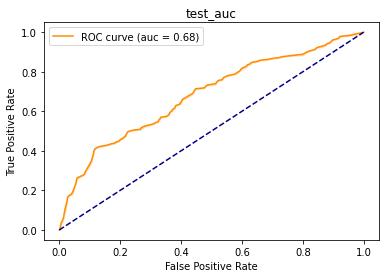

In [21]:
from sklearn.metrics import auc, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# 指標の計算

# ROC曲線の各点の値(閾値ごとのFPRとTPR)の計算
false_positive_rates, true_positive_rates, thresholds = roc_curve(y_test, pred_proba_test) 

# aucの計算
test_auc = auc(false_positive_rates, true_positive_rates)

# 描画の作成

# 描画オブジェクトの作成
fig, ax = plt.subplots(1, 1)

# ROC曲線の描画
sns.lineplot(x = false_positive_rates, 
             y = true_positive_rates, 
             color = 'darkorange', label = f'ROC curve (auc = {test_auc:.2f})', ax = ax)

# 座標(0, 0) ~ (1, 1)の直線の描画
sns.lineplot(x = [0, 1], 
             y = [0, 1], 
             color='navy', linestyle='--', ax = ax);

# 軸ラベルとタイトルの設定
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('test_auc');

# ノック22. 予測モデルのビジネスインパクトを算出する

In [22]:
# 金額のパラメータを設定
TRUE_POSITIVE_BENEFIT = 35876 #不合格品を正しく判定できた場合に削減できるコスト
FALSE_POSITIVE_COST = 9112 #合格品を誤って判定した場合に発生するコスト

# 混同行列を一次元に変換して、各要素を変数に格納
# tpは「不合格と判定された不合格サンプル」(true positiveの略)
# fpは「合格と判定された不合格サンプル」(false positiveの略)
cm = confusion_matrix(y_test, pred_label_test)
tn, fp, fn, tp = cm.flatten() 

# コストメリットを計算して保存
total_benefit = tp * TRUE_POSITIVE_BENEFIT - fp * FALSE_POSITIVE_COST

# 結果の確認
print('しきい値: ', threshold)
print('テストデータのサンプル数: ', y_test.shape[0])
print('コストメリット: ', total_benefit)


しきい値:  0.5
テストデータのサンプル数:  885
コストメリット:  1082532


# ノック23. 「予測確率」と「閾値」を引数として予測モデルの精度検証を行う関数を作成する

In [23]:
# 予測モデルの精度指標を計算する関数を定義
def calc_model_metrics(pred_proba_test, y_test, threshold):
    
    # ノック18 ----------------------------------------------------
    
    # 閾値以上なら1、そうでなければ0に変換
    pred_label_test = np.where(pred_proba_test >= threshold, 1, 0)

    # 結果の確認
    print('予測結果')
    print('------')
    print('予測が「不合格」のデータ数: ', pred_label_test[pred_label_test == 1].shape[0])
    print('予測が「合格」のデータ数: ', pred_label_test[pred_label_test == 0].shape[0])
    print('')
    
    # ノック19 ----------------------------------------------------
    # 指標の計算
    accuracy = accuracy_score(y_test, pred_label_test)
    precision = precision_score(y_test, pred_label_test)
    recall = recall_score(y_test, pred_label_test)
    f1 = f1_score(y_test, pred_label_test)

    # 指標の出力
    print('精度指標')
    print('------')
    print('Test Accuracy: ', accuracy.round(2))
    print('Test Precision: ', precision.round(2))
    print('Test Recall: ', recall.round(2))
    print('Test F1-score: ', f1.round(2))
    print('')
    
    # ノック20 ----------------------------------------------------
    
    # 混同行列を計算する
    cm_test = confusion_matrix(y_test, pred_label_test)

    # データフレームに変換する
    df_cm = pd.DataFrame(
        cm_test, 
        columns = np.unique(y_test), # カラム名を0, 1とする
        index = np.unique(y_test), # インデックス番号を0, 1とする
        )

    # インデックス名を設定
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Prediction'
    
    # 行・列どちらも0, 1の順になっているため、1, 0の順になるように並び替える
    df_cm = df_cm.sort_index(axis='index', ascending=False)
    df_cm = df_cm.sort_index(axis='columns', ascending=False)
    
    # 結果の確認
    print('混同行列')
    print('-----')
    print(df_cm)
    print('')
    
    # ノック21 ----------------------------------------------------
    
    # 指標の計算

    # ROC曲線の各点の値(閾値ごとのFPRとTPR)の計算
    false_positive_rates, true_positive_rates, thresholds = roc_curve(y_test, pred_proba_test) 

    # aucの計算
    test_auc = auc(false_positive_rates, true_positive_rates)

    # 描画の作成

    # 描画オブジェクトの作成
    fig, ax = plt.subplots(1, 1)

    # ROC曲線の描画
    sns.lineplot(x = false_positive_rates, 
                 y = true_positive_rates, 
                 color = 'darkorange', label = f'ROC curve (auc = {test_auc:.2f})', ax = ax)

    # 座標(0, 0) ~ (1, 1)の直線の描画
    sns.lineplot(x = [0, 1], 
                 y = [0, 1], 
                 color='navy', linestyle='--', ax = ax);

    # 軸ラベルとタイトルの設定
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('test_auc');
    
    # ノック22 ----------------------------------------------------

    # 金額のパラメータを設定
    TRUE_POSITIVE_BENEFIT = 35876 #不合格品を正しく判定できた場合に削減できるコスト
    FALSE_POSITIVE_COST = 9112 #合格品を誤って判定した場合に発生するコスト

    # 混同行列を一次元に変換して、各要素を変数に格納
    # tpは「不合格と判定された不合格サンプル」(true positiveの略)
    # fpは「合格と判定された不合格サンプル」(false positiveの略)
    cm = confusion_matrix(y_test, pred_label_test)
    tn, fp, fn, tp = cm.flatten() 

    # コストメリットを計算して保存
    total_benefit = tp * TRUE_POSITIVE_BENEFIT - fp * FALSE_POSITIVE_COST

    # 結果の確認
    print('ビジネスインパクトの概算')
    print('-----')
    print('しきい値:', threshold)
    print('データ数: ', y_test.shape[0])
    print('コストメリット:', total_benefit)
    print('')

予測結果
------
予測が「不合格」のデータ数:  54
予測が「合格」のデータ数:  831

精度指標
------
Test Accuracy:  0.78
Test Precision:  0.65
Test Recall:  0.16
Test F1-score:  0.26

混同行列
-----
Prediction   1    0
Actual             
1           35  180
0           19  651

ビジネスインパクトの概算
-----
しきい値: 0.5
データ数:  885
コストメリット: 1082532



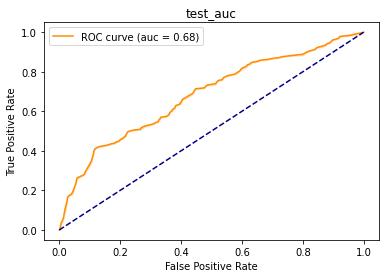

In [24]:
# 実行結果の確認
calc_model_metrics(pred_proba_test, y_test, threshold=0.5)

#これ以下は以前のサンプルとの共通部分

# ノック34. ビジネスインパクトに基づいて最適なしきい値を算出する

In [44]:
# 各閾値に対する結果の保存先を作成
total_benefits = [] # 各閾値に対するコストメリット
tns = []            # 各閾値に対する合格（正解）数
fps = []            # 各閾値に対する合格（不正解）数
fns = []            # 各閾値に対する不合格（不正解）数
tps = []            # 各閾値に対する不合格（正解）数

# 0.0～1.0まで0.01刻みの閾値のリストを作成
thresholds = np.arange(0.0, 1.0, 0.01)

for threshold in thresholds:
    
    # その閾値に対する予測ラベルを作成
    pred_label_test = np.where(pred_proba_test >= threshold, 1, 0)
    
    # 混同行列の各要素を取得する
    cm = confusion_matrix(y_test, pred_label_test)
    tn, fp, fn, tp = cm.flatten()
    
    # 混同行列の各要素を保存
    tns.append(tn)
    fps.append(fp)
    fns.append(fn)
    tps.append(tp)
    
    # コストメリットを計算して保存
    total_benefit = tp*TRUE_POSITIVE_BENEFIT - fp*FALSE_POSITIVE_COST
    total_benefits.append(total_benefit)

# 結果をデータフレームにまとめる
df_cost_result = pd.DataFrame({
    'しきい値': thresholds,
    'コストメリット': total_benefits,
    '合格（正解）': tns,
    '合格（不正解）': fns,
    '不合格(不正解)': fps,
    '不合格(正解)': tps,
})
    
# 結果の確認
df_cost_result.head(20)

,しきい値,コストメリット,合格（正解）,合格（不正解）,不合格(不正解),不合格(正解)
0,0.00,1608300,0,0,670,215
1,0.01,1608300,0,0,670,215
2,0.02,1608300,0,0,670,215
3,0.03,1608300,0,0,670,215
4,0.04,1608300,0,0,670,215
5,0.05,1599760,3,1,667,214
6,0.06,1627096,6,1,664,214
7,0.07,1645892,12,2,658,213
8,0.08,1628240,14,3,656,212
9,0.09,1566172,19,6,651,209


# ノック35. 最もコストメリットが高くなる閾値と金額を算出

In [40]:
# コストメリットが最も高くなるインデックス番号を取得
index_optimal = df_cost_result['コストメリット'].idxmax()

# 最もコストメリットが高くなる閾値と金額
df_cost_result.iloc[index_optimal]

しきい値              0.25
コストメリット     3186020.00
合格（正解）          496.00
合格（不正解）          82.00
不合格(不正解)        174.00
不合格(正解)         133.00
Name: 25, dtype: float64